## Data Preprocessing

In [1]:
# Imports
import numpy as np
import pandas as pd
# import dcMinMaxFunctions as dc
# import dcor
from scipy.misc import derivative
from sklearn.model_selection import train_test_split
import math
import torch
from scipy import stats
import wandb

In [2]:
df=pd.read_csv("data/Churn_Modelling.csv")

In [3]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [5]:
n=10000
d=12
h = n**(-1./(d+4))


In [6]:
df=pd.read_csv("data/Churn_Modelling.csv")
# df=df.drop(['duration', 'pdays'],axis=1) # duration gives away the answer, and pdays has too much missing info

X = df.loc[:, df.columns != 'Exited'].replace(dict(yes=True, no=False))
Y = df.loc[:, ['Exited']].replace(dict(yes=True, no=False))

In [7]:
categorical_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
outputs = ['Exited']

In [8]:
for category in categorical_columns:
    df[category] = df[category].astype('category')

In [9]:
def OHE(x):
    dim = np.max(x)
    y = np.zeros((len(x),dim+1))
    for i in range(len(x)):
        y[i][x[i]] = 1
    return(y)

In [10]:
geo = OHE(df['Geography'].cat.codes.values)
gen =  np.asarray(df['Gender'].cat.codes.values)
hcc =  np.asarray(df['HasCrCard'].cat.codes.values)
iam =  np.asarray(df['IsActiveMember'].cat.codes.values)

categorical_data = np.stack(( gen, hcc, iam), axis=1)
# categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
numerical_data = np.stack([df[col].values for col in numerical_columns], 1)
# numerical_data = torch.tensor(numerical_data, dtype=torch.float)
X = np.concatenate((numerical_data, categorical_data,geo), axis=1)
Y = df[outputs].values
# outputs = torch.tensor(df[outputs].values).flatten()

In [11]:
def normalize(x):
    x_normed = x / x.max(0, keepdim=True)[0]
    return x_normed



In [12]:
X = torch.Tensor(X)
Y = torch.Tensor(Y)
X = normalize(X)

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Estimating Data Densities

#### Gaussian Kernel Density Estimation & Derivative

In [21]:
def gau_ker(u):
    return torch.pow(2*torch.tensor(torch.pi),u.shape[1]/(-2))*torch.exp(torch.bmm(u.view(u.shape[0], 1, u.shape[1]), u.view(u.shape[0],  u.shape[1],1))/(-2))


def py_kde(x,X_t,h,device="cpu"):
    norm = X_t.shape[0]*(h**x.shape[1])
    prob = torch.zeros(x.shape[0]).to(device)
    for i in range(len(X_t)):
        prob+= (torch.squeeze(gau_ker((x - X_t[i])/h))/norm).to(device)
    return(prob)


def py_kde_der(p_x,x,device="cpu"):
    # x.requires_grad = True
    # p_x = py_kde(x,X_t,h)
    return (torch.autograd.grad(p_x,x,torch.ones_like(p_x),allow_unused=True,create_graph=True)[0]).to(device)


def gau_ker_der(X,h):
    N= X.shape[0]
    d = X.shape[1]
    grad = torch.zeros(X.shape)
    for n in range(N):
        for i in range(d):
            for j in range(N):
                grad[n][i]+= torch.exp(-1*torch.dot((X[n]-X[j]),(X[n]-X[j]))/(2*h*h))*(X[n][i] -X[j][i]) /(N*(h**(d+2))*((2*math.pi)**(d/2)))

    return grad

#### Confidence Intervals

In [22]:

def CI_KDE(p_x,n,h,d,alpha):
    return( stats.norm.ppf(1-alpha/2)*torch.sqrt(p_x/((2**d)*math.sqrt(torch.pi**d)*n*h**(d))) )

def CI_KDE_der(p_x_der,p_x,n,h,d,alpha):
    return( p_x_der*stats.norm.ppf(1-alpha/2)*torch.sqrt(1/(p_x.unsqueeze(dim=1)*(2**d)*math.sqrt(torch.pi**d)*n*h**(d))) )

#### Example on Data

In [23]:
device = torch.device("cpu")
x = X[0:100].detach().to(device)
x.requires_grad = True
f = py_kde(x,x,h)
f_der = py_kde_der(f,x)

In [24]:
n = X.shape[0]
d = X.shape[1]
alpha =0.01

In [18]:
ci = CI_KDE(f,n,h,d,alpha)
ci_der = CI_KDE_der(f_der,f,n,h,d,alpha)

In [19]:
ci/f

tensor([0.0127, 0.0176, 0.0145, 0.0136, 0.0152, 0.0165, 0.0130, 0.0179, 0.0147,
        0.0127, 0.0147, 0.0157, 0.0137, 0.0141, 0.0124, 0.0158, 0.0171, 0.0144,
        0.0165, 0.0130, 0.0124, 0.0151, 0.0147, 0.0157, 0.0136, 0.0142, 0.0153,
        0.0153, 0.0126, 0.0139, 0.0157, 0.0144, 0.0152, 0.0132, 0.0134, 0.0148,
        0.0149, 0.0136, 0.0123, 0.0164, 0.0155, 0.0160, 0.0136, 0.0155, 0.0153,
        0.0122, 0.0133, 0.0131, 0.0157, 0.0168, 0.0189, 0.0141, 0.0131, 0.0154,
        0.0161, 0.0129, 0.0137, 0.0173, 0.0176, 0.0116, 0.0142, 0.0197, 0.0182,
        0.0165, 0.0144, 0.0135, 0.0160, 0.0161, 0.0177, 0.0135, 0.0195, 0.0143,
        0.0195, 0.0126, 0.0149, 0.0153, 0.0120, 0.0135, 0.0150, 0.0174, 0.0140,
        0.0134, 0.0144, 0.0129, 0.0131, 0.0145, 0.0164, 0.0145, 0.0125, 0.0130,
        0.0144, 0.0142, 0.0132, 0.0126, 0.0150, 0.0161, 0.0146, 0.0152, 0.0171,
        0.0163], device='cuda:0', grad_fn=<DivBackward0>)

In [20]:
ci_der/f_der

tensor([[0.0127, 0.0127, 0.0127,  ..., 0.0127, 0.0127, 0.0127],
        [0.0176, 0.0176, 0.0176,  ..., 0.0176, 0.0176, 0.0176],
        [0.0145, 0.0145, 0.0145,  ..., 0.0145, 0.0145, 0.0145],
        ...,
        [0.0152, 0.0152, 0.0152,  ..., 0.0152, 0.0152, 0.0152],
        [0.0171, 0.0171, 0.0171,  ..., 0.0171, 0.0171, 0.0171],
        [0.0163, 0.0163, 0.0163,  ..., 0.0163, 0.0163, 0.0163]],
       device='cuda:0', grad_fn=<DivBackward0>)

## Training the model

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self,p):
        super(Net, self ).__init__()
        
        self.loss_reg = 0
        self.p =p 
        self.x = 0
        self.y = 0
        self.H_net1 = nn.Sequential(
            nn.Linear(12, 48),
            nn.Sigmoid(),
            nn.Linear(48, 24),
            nn.Sigmoid(),
            nn.Linear(24, 144).cuda()

        )
        self.X_net = nn.Sequential(
            nn.Linear(12, 48),
            nn.ReLU(),
            nn.Linear(48, 48),
            nn.ReLU(),
            nn.Linear(48, 1),
            nn.Sigmoid()

        )
        
    def forward(self, x):
        def H_mul(z):
            H12 = self.H_net1(z)
            H12= H12.reshape(z.shape[0],d,d)
            x12 = torch.matmul(z,H12)
            return(x12)
    
        
        def batch_jacobian(func, z, create_graph=False):
            # x in shape (Batch, Length)
            def _func_sum(z):
                return func(z).sum(dim=0)
            return torch.squeeze(torch.autograd.functional.jacobian(_func_sum, z, create_graph=create_graph)).permute(1,0,2)
        
        x.requires_grad =True
        p = self.p
        self.x = x
        d = x.shape[1]
        bs = x.shape[0]
        x= torch.unsqueeze(x,1)
        z = x.cuda()
        loss_reg = torch.zeros(bs,d).cuda()
        for i in range(p):
            H = self.H_net1(z).cuda()
            H = H.reshape(bs,d,d)
            z = torch.matmul(z,H).cuda()
            J = batch_jacobian(H_mul, z, create_graph=True)
            J_int =-torch.log(torch.abs(torch.det(J)))
            loss_reg = loss_reg + torch.squeeze(torch.autograd.grad(J_int, x,torch.ones_like(J_int),allow_unused=True,create_graph= True)[0]).cuda()
        self.loss_reg = loss_reg
        self.y = z
        y = self.X_net(z)
        return y

In [28]:
net = Net(5).cuda()
net(X_train[0:3].cuda())

tensor([[[0.5141]],

        [[0.5098]],

        [[0.5048]]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [33]:
net.loss_reg - f_der[0:3]/f[0:3].view(f[0:3].shape[0],1)

tensor([[ 6.9095e-04,  4.9341e-01, -1.6925e+00, -6.9037e-01, -3.9101e-01,
          7.4632e-02, -1.0352e+00,  7.3446e-01,  1.3224e+00,  6.9073e-01,
         -1.8250e-01, -1.0579e-01],
        [-8.4459e-02,  3.8064e-01, -1.8119e+00,  1.5441e-01, -2.2724e-01,
          3.8045e-01, -1.2734e+00, -1.3989e+00,  8.0199e-01, -2.6416e-01,
         -1.8800e-01,  8.5170e-01],
        [-4.7505e-01,  5.3439e-01,  6.8088e-01,  1.9595e+00,  1.3813e+00,
          6.8535e-01, -7.1692e-01,  1.1159e+00, -6.7239e-01,  6.5306e-01,
         -2.0656e-01,  1.4894e-02]], device='cuda:0', grad_fn=<SubBackward0>)

In [41]:
import torch.optim as optim

criterion = nn.BCELoss(reduction= 'none')
def my_loss(y_pred,y_train,reg_loss):
    loss = criterion(y_pred,y_train) +reg_loss
    return loss
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
torch.autograd.set_detect_anomaly(False)
net_5 = Net(5)
import torch.optim.lr_scheduler as lr_scheduler
 


In [42]:
net_5= net_5.cuda()
data=X
batch_size = 1
epochs = 30
Y = Y.cuda()
opt1 = torch.optim.Adam(net_5.parameters(),lr=0.0003)
# scheduler = lr_scheduler.LinearLR(opt1, start_factor=1.0, end_factor=0.1, total_iters=10)
net_5.train()
bs = 500
for epoch in range(epochs):
    losses = 0
    losses_reg = 0
    for ct in range(0,len(X),bs):
        x = data[ct:bs+ct].detach().cuda()

        opt1.zero_grad()
        x_hat = net_5(x)
        # f = py_kde(x,x,0.65)
        f_x = py_kde(x,x,0.65)
        f_x_der = py_kde_der(f_x,x)
        loss = criterion(torch.squeeze(x_hat[0:,0:,0]),torch.squeeze(Y[ct:bs+ct])) +torch.linalg.norm(f_x_der/f_x.view(f_x.shape[0],1)+ net_5.loss_reg,dim=1)
        loss.backward(torch.ones_like(loss), retain_graph=True)
        losses+=torch.sum(loss)/len(X)
        losses_reg+=torch.sum(torch.linalg.norm(f_x_der/f_x.view(f_x.shape[0],1)+net_5.loss_reg,dim=1)/len(X))
        opt1.step()
    print("Epoch number:",epoch,"  Iteration number:",ct," LR :",opt1.param_groups[0]["lr"], " Loss:",losses, "Reg Loss:",losses_reg)
    # if(epoch%20==19):
    #     scheduler.step()


Epoch number: 0   Iteration number: 9500  LR : 0.0003  Loss: tensor(3.6986, device='cuda:0', grad_fn=<AddBackward0>) Reg Loss: tensor(2.9626, device='cuda:0', grad_fn=<AddBackward0>)
Epoch number: 1   Iteration number: 9500  LR : 0.0003  Loss: tensor(3.6042, device='cuda:0', grad_fn=<AddBackward0>) Reg Loss: tensor(2.9090, device='cuda:0', grad_fn=<AddBackward0>)
Epoch number: 2   Iteration number: 9500  LR : 0.0003  Loss: tensor(3.5589, device='cuda:0', grad_fn=<AddBackward0>) Reg Loss: tensor(2.9030, device='cuda:0', grad_fn=<AddBackward0>)
Epoch number: 3   Iteration number: 9500  LR : 0.0003  Loss: tensor(3.5036, device='cuda:0', grad_fn=<AddBackward0>) Reg Loss: tensor(2.8925, device='cuda:0', grad_fn=<AddBackward0>)
Epoch number: 4   Iteration number: 9500  LR : 0.0003  Loss: tensor(3.4212, device='cuda:0', grad_fn=<AddBackward0>) Reg Loss: tensor(2.8622, device='cuda:0', grad_fn=<AddBackward0>)
Epoch number: 5   Iteration number: 9500  LR : 0.0003  Loss: tensor(3.3082, device='c

In [47]:
import torch.optim as optim

criterion = nn.BCELoss(reduction= 'none')
def my_loss(y_pred,y_train,reg_loss):
    loss = criterion(y_pred,y_train) +reg_loss
    return loss
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
torch.autograd.set_detect_anomaly(False)
net_10 = Net(10)
import torch.optim.lr_scheduler as lr_scheduler

In [53]:
net_10= net_10.cuda()
# data=X.cuda()
batch_size = 1
epochs = 10
Y = Y.cuda()
opt1 = torch.optim.Adam(net_10.parameters(),lr=0.0001)
# scheduler = lr_scheduler.LinearLR(opt1, start_factor=1.0, end_factor=0.1, total_iters=10)
net_10.train()
bs = 1000
for epoch in range(epochs):
    losses = 0
    losses_reg = 0
    for ct in range(0,len(X),bs):
        x = data[ct:bs+ct].detach().cuda()

        opt1.zero_grad()
        x_hat = net_10(x)
        # f = py_kde(x,x,0.65)
        f_x = py_kde(x,x,0.65)
        f_x_der = py_kde_der(f_x,x)
        #loss = torch.linalg.norm(f_x_der/f_x.view(f_x.shape[0],1)+ net_10.loss_reg,dim=1)
        loss = criterion(torch.squeeze(x_hat[0:,0:,0]),torch.squeeze(Y[ct:bs+ct])) +torch.linalg.norm(f_x_der/f_x.view(f_x.shape[0],1)+ net_10.loss_reg,dim=1)
        loss.backward(torch.ones_like(loss), retain_graph=True)
        opt1.step()
        losses+=torch.sum(loss)/len(X)
        losses_reg+=torch.sum(torch.linalg.norm(f_x_der/f_x.view(f_x.shape[0],1)+net_10.loss_reg,dim=1)/len(X))

    print("Epoch number:",epoch,"  Iteration number:",ct," LR :",opt1.param_groups[0]["lr"], " Loss:",losses, "Reg Loss:",losses_reg)
    # if(epoch%20==19):

Epoch number: 0   Iteration number: 9000  LR : 0.0001  Loss: tensor(1.6387, device='cuda:0', grad_fn=<AddBackward0>) Reg Loss: tensor(1.1740, device='cuda:0', grad_fn=<AddBackward0>)
Epoch number: 1   Iteration number: 9000  LR : 0.0001  Loss: tensor(1.5847, device='cuda:0', grad_fn=<AddBackward0>) Reg Loss: tensor(1.1204, device='cuda:0', grad_fn=<AddBackward0>)
Epoch number: 2   Iteration number: 9000  LR : 0.0001  Loss: tensor(1.5610, device='cuda:0', grad_fn=<AddBackward0>) Reg Loss: tensor(1.0967, device='cuda:0', grad_fn=<AddBackward0>)
Epoch number: 3   Iteration number: 9000  LR : 0.0001  Loss: tensor(1.5477, device='cuda:0', grad_fn=<AddBackward0>) Reg Loss: tensor(1.0831, device='cuda:0', grad_fn=<AddBackward0>)
Epoch number: 4   Iteration number: 9000  LR : 0.0001  Loss: tensor(1.5388, device='cuda:0', grad_fn=<AddBackward0>) Reg Loss: tensor(1.0743, device='cuda:0', grad_fn=<AddBackward0>)
Epoch number: 5   Iteration number: 9000  LR : 0.0001  Loss: tensor(1.5335, device='c

## Upper bound on Epsilon


In [54]:
data=X



losses= torch.zeros(X.shape[0])
bs = 1000
n = bs
h = 0.65
d = X.shape[1]
alpha= 0.01
for ct in range(0,len(X),bs):
    x = data[ct:bs+ct].detach()
    x_hat = net_10(x)
    f = py_kde(x,x,0.65)
    f_der = py_kde_der(f,x)
    ci = CI_KDE(f,n,h,d,alpha)
    loss =torch.max(torch.linalg.norm(f_der/(f-ci).view(f.shape[0],1)+net_10.loss_reg,dim=1),torch.linalg.norm(f_der/(f+ci).view(f.shape[0],1)+net_10.loss_reg,dim=1)) 
    losses[ct:bs+ct] =loss

In [64]:
(losses*2.7<5).sum()

tensor(9592)

In [81]:
# with torch.no_grad():
net_10 = net_10.eval()
net_10 = net_10.cuda()


In [85]:
net_10(X_test[0:10].cuda())

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.73 GiB total capacity; 13.64 GiB already allocated; 74.19 MiB free; 14.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [80]:
y_pred = net_10(X.cpu())
 

# accuracy = (y_pred.round() == Y.cpu()).float().mean()
# print(f"Accuracy {accuracy}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.73 GiB total capacity; 13.64 GiB already allocated; 74.19 MiB free; 14.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

0.6493816315762113

In [102]:
(losses).sum()

tensor(14698.5742, grad_fn=<SumBackward0>)

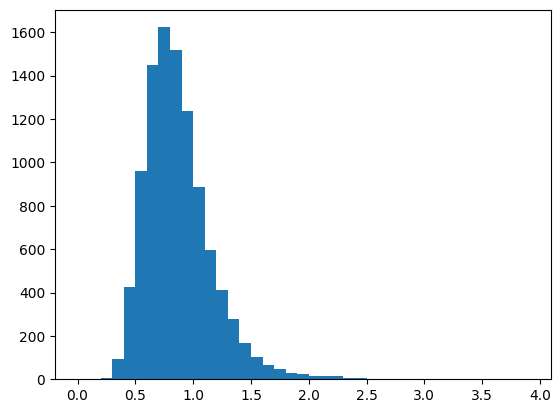

In [191]:

from matplotlib import pyplot as plt
import numpy as np
 
 
# Creating dataset
a = losses.detach()
 
# Creating histogram
fig, ax = plt.subplots()
ax.hist(a, bins = np.arange(0,4,0.1))
 
# Show plot
plt.show()

In [165]:
o = autoencoder1(X_train.detach())
X_emb_train = torch.squeeze(autoencoder1.y).detach()
o = autoencoder1(X_test.detach())
X_emb_test = torch.squeeze(autoencoder1.y).detach()


In [176]:

# o = autoencoder1(X)
# X_embs = torch.squeeze(autoencoder1.y.detach())
model = nn.Sequential(
    nn.Linear(12, 48),
    nn.ReLU(),
    nn.Linear(48, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(

    )
)
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 2000
batch_size = 1000

for epoch in range(n_epochs):
    for i in range(0, len(X_emb_train), batch_size):
        Xbatch = X_emb_train[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = Y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #     print(loss)
    # print(f'Finished epoch {epoch}, latest loss {loss}')
# compute accuracy (no_grad is optional)
with torch.no_grad():
    y_pred = model(X_emb_test)
 
accuracy = (y_pred.round() == Y_test).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.8339999914169312


In [167]:
model1 = nn.Sequential(
    nn.Linear(12, 48),
    nn.ReLU(),
    nn.Linear(48, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(

    )
)
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
n_epochs = 1000
batch_size = 1000
 
for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = model1(Xbatch)
        ybatch = Y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

with torch.no_grad():
    y_pred = model1(X_test)
 
accuracy = (y_pred.round() == Y_test).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.871999979019165
